In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

# Load the data (replace with your dataset file if applicable)
data = pd.read_csv('https://drive.google.com/uc?id=18Hz8VSLDWvM0GwNuXyBUKoGNPhYKVzFF') 
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Prepare data
sequence_length = 48
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]  # Next point is the label
        sequences.append((seq, label))
    return np.array(sequences)

true_anomalies_dates = [
    '2014-11-02', '2014-11-27', '2014-12-25',
    '2015-01-01',
    '2015-01-26', '2015-01-27'
]

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Add true anomaly labels to the DataFrame
data['is_anomaly'] = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)

C:\Users\aqils\AppData\Local\Temp\ipykernel_21140\4236775668.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 48, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
257/257 [==============================] 

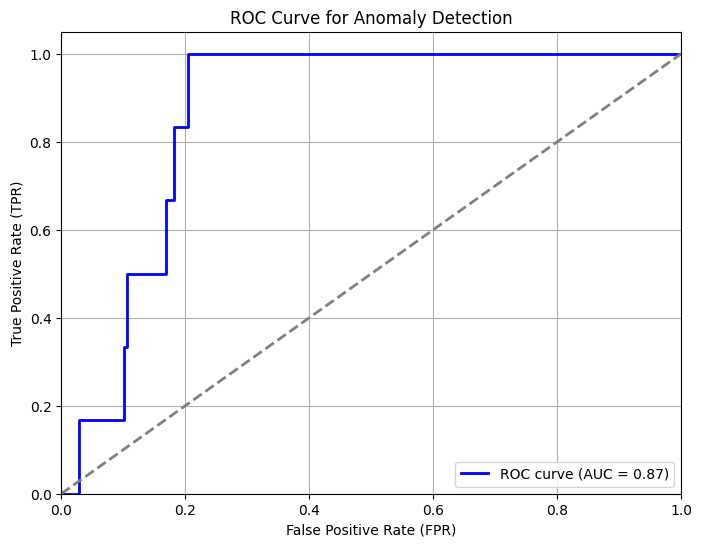

In [2]:
sequences1 = create_sequences(scaled_data, sequence_length)
X1, y1 = zip(*sequences1)
X1, y1 = np.array(X1), np.array(y1)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X1.shape[1], X1.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(X1.shape[2])
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X1, y1, epochs=10, batch_size=32, validation_split=0.2)

# Predict and calculate reconstruction error
predictions = model.predict(X1)

# Use only the last timestep of X for comparison, as predictions correspond to the last timestep
X1_last = X1[:, -1, :]  # Extract the last timestep of each sequence

# Compute reconstruction errors
reconstruction_error1 = np.mean(np.abs(predictions - X1_last), axis=1)

# Anomaly detection: True anomaly indices
true_anomalies_indices = data.index.isin(pd.to_datetime(true_anomalies_dates))[sequence_length:]
true_anomalies_errors = reconstruction_error1[true_anomalies_indices]

# Calculate minimum and average error for true anomalies
min_error = np.min(true_anomalies_errors)
avg_error = np.mean(true_anomalies_errors)

print(f"Minimum reconstruction error for true anomalies: {min_error:.4f}")
print(f"Average reconstruction error for true anomalies: {avg_error:.4f}")

# Compute ROC curve and AUC using reconstruction error
true_labels1 = data['is_anomaly'].values[sequence_length:]  # Use .values only if data['is_anomaly'] is a Series
fpr1, tpr1, thresholds1 = roc_curve(true_labels1, reconstruction_error1)
roc_auc1 = auc(fpr1, tpr1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Anomaly Detection')
plt.legend(loc="lower right")
plt.grid()
plt.show()

C:\Users\aqils\AppData\Local\Temp\ipykernel_21140\4236775668.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 64)            18432     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 48, 32)           0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 48, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 48, 64)            24832     
                                                             

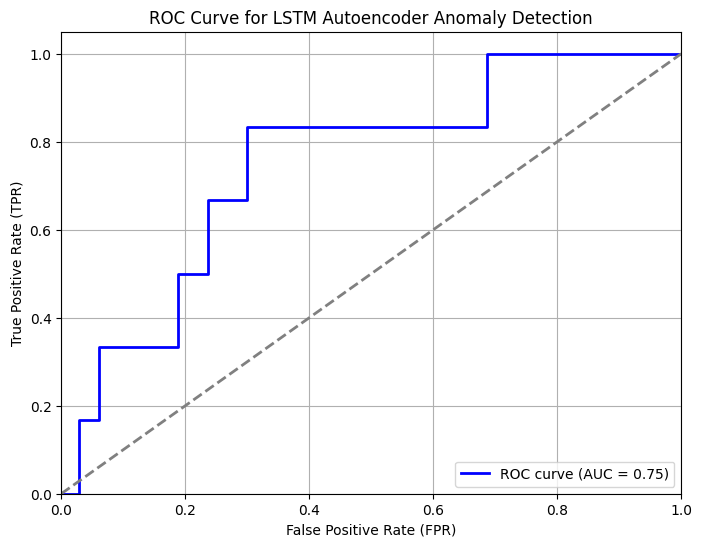

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

# Create sequences for input
sequences2 = create_sequences(scaled_data, sequence_length)
X2 = np.array([seq[0] for seq in sequences2])  # Input data as 3D array (samples, timesteps, features)

# Define the input shape for LSTM (timesteps, features)
timesteps = X2.shape[1]  # Number of timesteps in the sequence
features = X2.shape[2]   # Number of features per timestep

# Encoder
input_layer = Input(shape=(timesteps, features))
encoded = LSTM(64, activation="relu", return_sequences=True)(input_layer)
encoded = LSTM(32, activation="relu", return_sequences=False)(encoded)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation="relu", return_sequences=True)(decoded)
decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features, activation="sigmoid"))(decoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# Train the Autoencoder
history = autoencoder.fit(
    X2, X2,  # Using the original sequences as both input and target
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Predict reconstructed sequences
reconstructed = autoencoder.predict(X2)

# Calculate reconstruction error
reconstruction_error2 = np.mean(np.abs(reconstructed - X2), axis=(1, 2))

# True anomaly labels (adjust for sequence length offset)
true_anomalies2 = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
true_anomalies2 = true_anomalies2[sequence_length:]  # Align with sequence offset

# Compute ROC curve and AUC
fpr2, tpr2, thresholds2 = roc_curve(true_anomalies2, reconstruction_error2)
roc_auc2 = auc(fpr2, tpr2)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LSTM Autoencoder Anomaly Detection')
plt.legend(loc="lower right")
plt.grid()
plt.show()

C:\Users\aqils\AppData\Local\Temp\ipykernel_21140\4236775668.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_7 (ConvLSTM2D)  (None, 48, 1, 6, 64)      33536     
                                                                 
 batch_normalization_3 (Batc  (None, 48, 1, 6, 64)     256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 1, 5, 32)          24704     
                                                                 
 flatten_2 (Flatten)         (None, 160)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               20608     
                                                                 
 dense_7 (Dense)             (None, 336)               43344     
                                                      

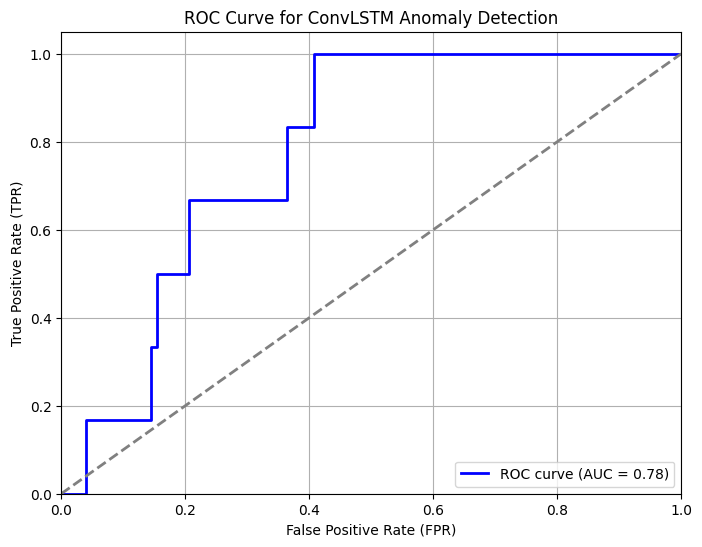

In [11]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten

# Create sequences for ConvLSTM2D input
sequences3 = create_sequences(scaled_data, sequence_length)
X3 = np.array([seq[0] for seq in sequences3])  # Input data as 3D array (samples, timesteps, features)

# Reshape for ConvLSTM2D: (samples, timesteps, rows, cols, channels)
X3 = X3.reshape((X3.shape[0], X3.shape[1], 1, X3.shape[2], 1))

# Build ConvLSTM model
model = Sequential([
    ConvLSTM2D(
        filters=64, kernel_size=(1, 2), activation='relu',
        input_shape=(X3.shape[1], 1, X3.shape[3], 1),
        return_sequences=True
    ),
    BatchNormalization(),
    ConvLSTM2D(
        filters=32, kernel_size=(1, 2), activation='relu',
        return_sequences=False
    ),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(X3.shape[1] * X3.shape[3], activation='sigmoid')  # Output layer matches flattened input
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the ConvLSTM model
X3_flattened = X3.reshape(X3.shape[0], -1)  # Flatten sequences for training output
history = model.fit(
    X3, X3_flattened,  # Input is 5D, target is flattened
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Predict and calculate reconstruction error
reconstructed = model.predict(X3).reshape(X3.shape[0], -1)
reconstruction_error3 = np.mean(np.abs(reconstructed - X3_flattened), axis=1)

# Ensure true_labels are aligned with the number of samples
true_labels3 = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
true_labels3 = true_labels3[sequence_length:]  # Adjust for sequence offset

# Compute ROC curve and AUC
fpr3, tpr3, thresholds3 = roc_curve(true_labels3[:len(reconstruction_error3)], reconstruction_error3)
roc_auc3 = auc(fpr3, tpr3)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr3, tpr3, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ConvLSTM Anomaly Detection')
plt.legend(loc="lower right")
plt.grid()
plt.show()

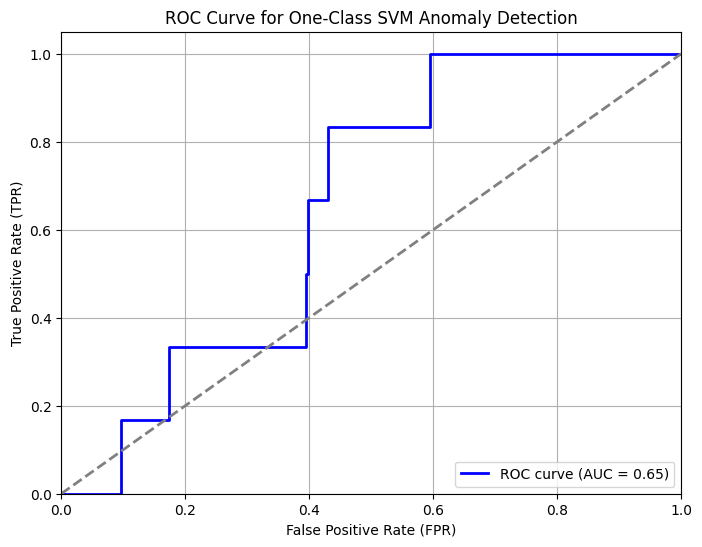

In [5]:
from sklearn.svm import OneClassSVM

# Train One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm.fit(scaled_data)

# Predict anomalies
scores4 = -svm.decision_function(scaled_data)

# data['is_anomaly'] = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)
true_labels4 = data['is_anomaly'].values

# Compute ROC curve and AUC
fpr4, tpr4, thresholds4 = roc_curve(true_labels4, scores4)
roc_auc4 = auc(fpr4, tpr4)

# plt.figure(figsize=(8, 6))
# plt.hist(scores[true_labels == 0], bins=50, alpha=0.5, label='Normal', color='blue')
# plt.hist(scores[true_labels == 1], bins=50, alpha=0.5, label='Anomalies', color='red')
# plt.title("Decision Score Distribution")
# plt.xlabel("Score")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr4, tpr4, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc4:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for One-Class SVM Anomaly Detection')
plt.legend(loc="lower right")
plt.grid()
plt.show()

C:\Users\aqils\AppData\Local\Temp\ipykernel_21140\4236775668.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


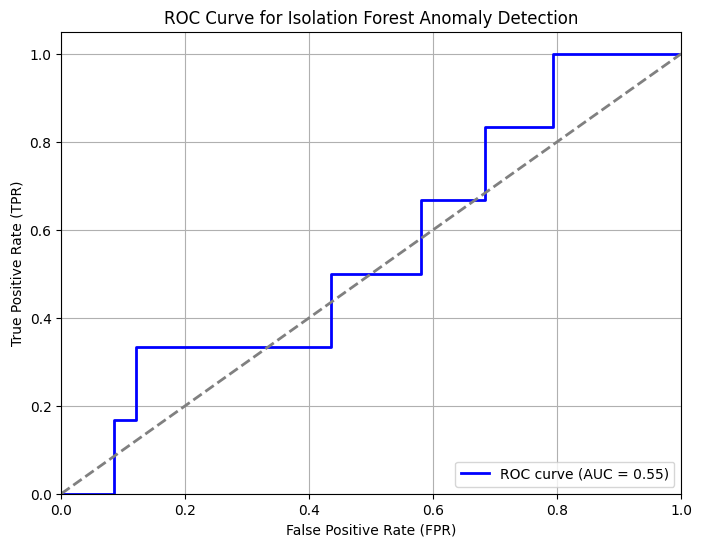

AUC for Isolation Forest Model: 0.55


In [9]:
# Create sequences for Isolation Forest input
sequences5 = create_sequences(scaled_data, sequence_length)
X5 = np.array([seq[0] for seq in sequences5])  # Input data as 3D array (samples, timesteps, features)

# Reshape to 2D array suitable for Isolation Forest: (samples, features)
X5_flattened = X5.reshape(X5.shape[0], -1)  

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X5_flattened)

# Anomaly scores
scores5 = -iso_forest.decision_function(X5_flattened)  # Higher scores indicate anomalies

# Create true labels for ROC curve (assuming data.index is datetime and true_anomalies_dates is a list of anomaly dates)
true_labels5 = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)[sequence_length:]  # Adjust for sequence offset

# Compute ROC curve and AUC
fpr5, tpr5, thresholds5 = roc_curve(true_labels5, scores5)
roc_auc5 = auc(fpr5, tpr5)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr5, tpr5, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc5:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Isolation Forest Anomaly Detection')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print the AUC score
print(f"AUC for Isolation Forest Model: {roc_auc5:.2f}")


In [7]:
# from statsmodels.tsa.seasonal import STL

# # data = pd.read_csv('https://drive.google.com/uc?id=18Hz8VSLDWvM0GwNuXyBUKoGNPhYKVzFF') 
# # data['timestamp'] = pd.to_datetime(data['timestamp'])
# # data.set_index('timestamp', inplace=True)

# # Select one column for STL decomposition (e.g., value)
# column_to_decompose = 'value'
# # Ensure the timestamp index has a uniform frequency
# data = data.asfreq('30T')  # Set frequency to 30 minutes (adjust as needed)

# # Re-select the column for decomposition after setting frequency
# data_to_decompose = data[column_to_decompose]

# # Apply STL decomposition
# stl = STL(data_to_decompose, seasonal=13)
# result = stl.fit()

# # Residual anomaly detection
# residuals = result.resid
# threshold = 3 * np.std(residuals)  # Define anomaly threshold
# anomalies = np.abs(residuals) > threshold

# # Add anomaly flag to the dataset
# data['is_anomaly'] = anomalies.astype(int)

# # Generate true anomaly labels (1 for anomaly, 0 for normal)
# data['true_anomaly'] = data.index.isin(pd.to_datetime(true_anomalies_dates)).astype(int)

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(data['true_anomaly'], data['is_anomaly'])
# roc_auc = auc(fpr, tpr)

# # Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('ROC Curve for STL+Residual Anomaly Detection')
# plt.legend(loc="lower right")
# plt.grid()
# plt.show()